In [100]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [101]:
def list_unzip_files(folder_path, unzip_dbf=False):
    # List all files in the folder
    all_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            relative_path = os.path.relpath(os.path.join(root, file), folder_path)
            all_files.append(relative_path)
    # If there are any dbf zip files, unzip them
    if unzip_dbf:
        for file_path in files:
            if file_path.endswith('.zip'):
                if not os.path.exists(f"{folder_path}/{file_path[:-4]}"):
                    with zipfile.ZipFile(f"{folder_path}/{file_path}", 'r') as zip_ref:
                        zip_ref.extractall(folder_path)
    return all_files

In [102]:
def filter_data_border(data, path_to_border):
    # Load the shapefile containing the administrative borders of Ukraine
    ukraine_borders = gpd.read_file(path_to_border)
    # Ensure the data is a GeoDataFrame
    data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.LONGITUDE, data.LATITUDE))
    # Set the same coordinate reference system (CRS) for both GeoDataFrames
    data_gdf.set_crs(epsg=4326, inplace=True)
    ukraine_borders.set_crs(epsg=4326, inplace=True)
    # Perform a spatial join to filter datapoints within Ukraine borders
    data_in_ukraine = gpd.sjoin(data_gdf, ukraine_borders, how='inner')
    # Drop the geometry column as it's no longer needed
    data_in_ukraine.drop(columns=['geometry', 'source', 'name', 'index_right'], inplace=True)
    # Reset the index
    data_in_ukraine.reset_index(drop=True, inplace=True)
    # Make sure all columns are in uppercase
    data_in_ukraine.columns = map(str.upper, data_in_ukraine.columns)
    # Rename the ID column to OBLAST_ID
    data_in_ukraine.rename(columns={'ID': 'OBLAST_ID'}, inplace=True)
    # Generate a unique identifier for each grid cell
    data_in_ukraine['GRID_CELL'] = data_in_ukraine['LATITUDE'].astype(str) + '_' + data_in_ukraine['LONGITUDE'].astype(str)
    return data_in_ukraine

In [103]:
def merge_dataframes(dataframes):
    # Merge the dataframes
    merged_df = pd.concat(dataframes, ignore_index=True)
    # Drop rows that are not in the Ukraine borders
    merged_df = filter_data_border(merged_df, 'input_data/raw/ukr_borders/ua.shp')
    # Reset the index
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

In [104]:
def plot_ukr_fires(data, path_to_border, title, colors=['red'], alphas=[0.25], markersizes=[1], 
                   legend=False, cmaps=[None], columns=[None], longitudes='LONGITUDE', latitudes='LATITUDE'):
    # Load the shapefile containing the administrative borders of Ukraine
    ukraine_borders = gpd.read_file(path_to_border)
    # Ensure the data is a GeoDataFrame
    data_gdf = []
    for i in range(len(data)):
        data_gdf.append(gpd.GeoDataFrame(data[i], geometry=gpd.points_from_xy(data[i][longitudes], data[i][latitudes])))
    # Set the same coordinate reference system (CRS) for all GeoDataFrames
    for i in range(len(data)):
        data_gdf[i].set_crs(epsg=4326, inplace=True)
    ukraine_borders.set_crs(epsg=4326, inplace=True)
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))
    ukraine_borders.plot(ax=ax, color='white', edgecolor='black')
    for i in range(len(data)):
        if columns[i] is not None:
            data_gdf[i].plot(ax=ax, column=columns[i], cmap=cmaps[i], markersize=markersizes[i], alpha=alphas[i], legend=legend)
        else:
            data_gdf[i].plot(ax=ax, color=colors[i], markersize=markersizes[i], alpha=alphas[i], legend=legend)
    plt.title(title)
    plt.show()

In [141]:
def plot_significance_score_histogram(fire_data):
    # Extract the SIGNIFICANCE_SCORE for normal and abnormal fires
    normal_fires_score = fire_data[0]['SIGNIFICANCE_SCORE']
    abnormal_fires_score = fire_data[1]['SIGNIFICANCE_SCORE']

    # Plot histograms
    plt.figure(figsize=(12, 3))

    # Histogram for normal fires
    plt.subplot(1, 2, 1)
    plt.hist(normal_fires_score, bins=30, color='blue', alpha=0.7)
    plt.title('Histogram of SIGNIFICANCE_SCORE for Normal Fires')
    plt.xlabel('SIGNIFICANCE_SCORE')
    plt.xlim(0, 1)
    plt.ylabel('Frequency')

    # Histogram for abnormal fires
    plt.subplot(1, 2, 2)
    plt.hist(abnormal_fires_score, bins=30, color='red', alpha=0.7)
    plt.title('Histogram of SIGNIFICANCE_SCORE for Abnormal Fires')
    plt.xlabel('SIGNIFICANCE_SCORE')
    plt.xlim(0, 1)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

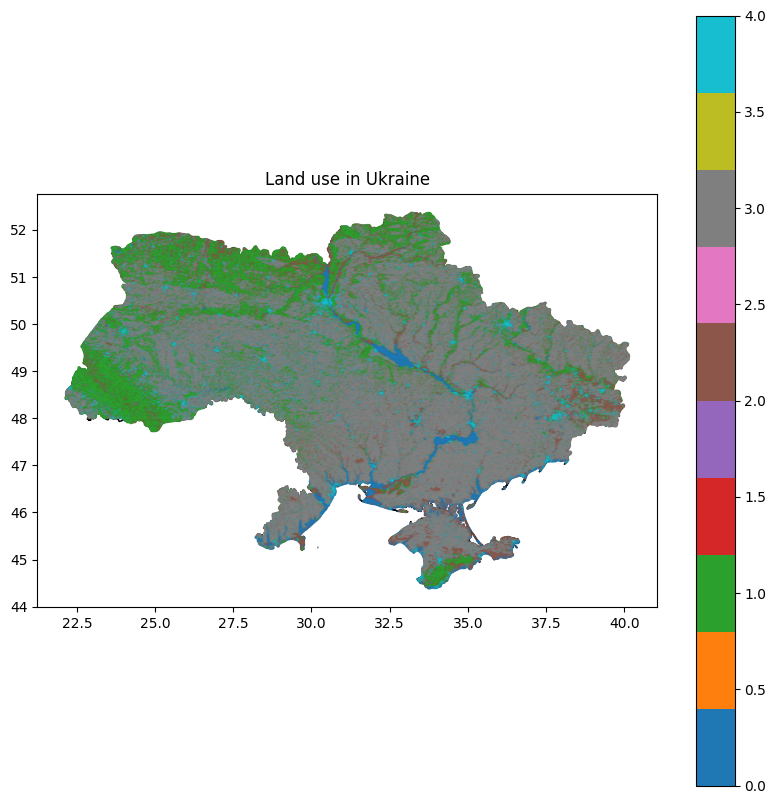

In [29]:
# Load all csv files in the folder
dataframes = []
for csv_file in list_unzip_files('input_data/processed/land_use'):
    if csv_file.endswith('001.csv') and csv_file[:-8] in [x[:-4] for x in list_unzip_files('input_data/raw/land_use')]:
        dataframes.append(pd.read_csv(f"input_data/processed/land_use/{csv_file}"))
# Merge the dataframes
land_use_data = [merge_dataframes(dataframes)]

plot_ukr_fires(land_use_data, 'input_data/raw/ukr_borders/ua.shp', 
               'Land use in Ukraine', 
               cmaps=['tab10'], alphas=[0.25], markersizes=[1], columns=['CLASS'], legend=True)

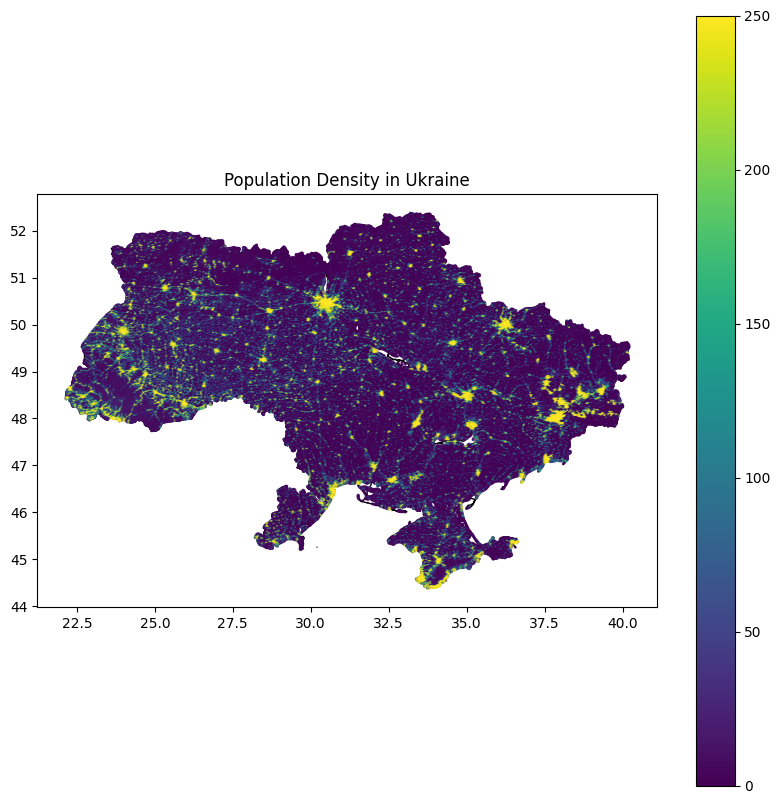

In [30]:
# Load population data
population_data = pd.read_csv('input_data/raw/population/ukr_pd_2020_1km_UNadj_ASCII_XYZ.csv')

# Assign all rows with a value greater than 500 to 500
population_data['Z'] = population_data['Z'].apply(lambda x: 250 if x > 250 else x)

# Color the grid cells by population density, which is a continuous variable
data = plot_ukr_fires([population_data], 'input_data/raw/ukr_borders/ua.shp', 
               'Population Density in Ukraine', 
               cmaps=['viridis'], alphas=[0.25], markersizes=[1], columns=['Z'], legend=True, longitudes='X', latitudes='Y')

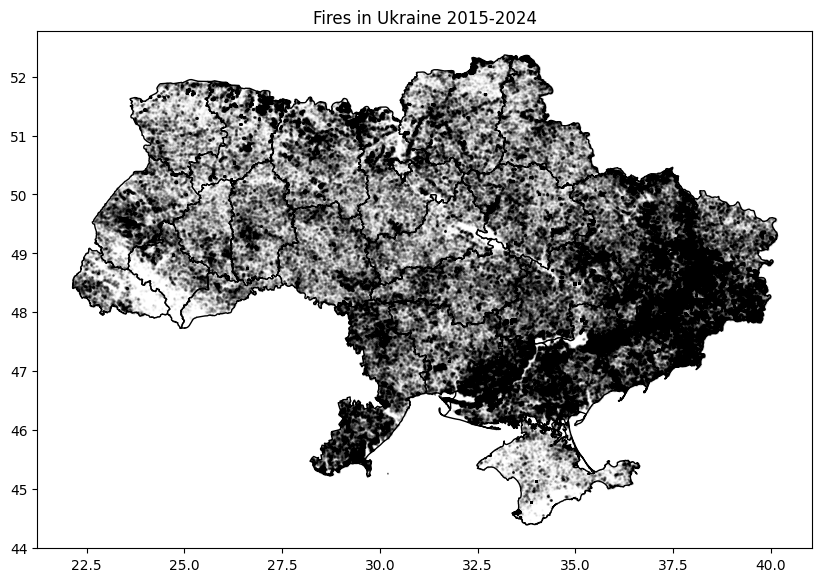

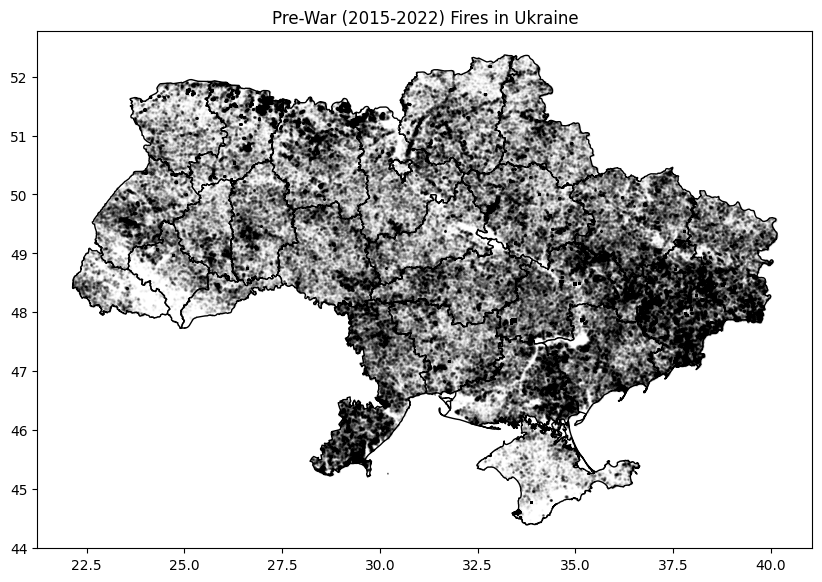

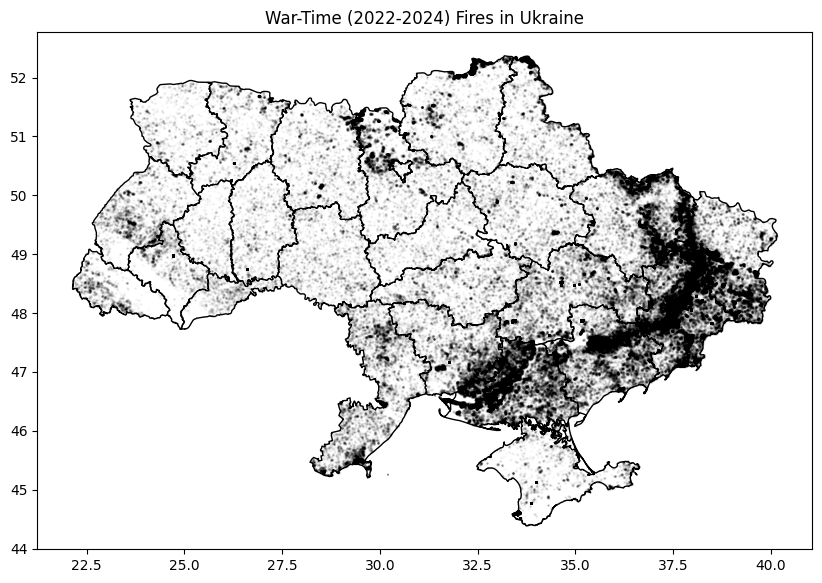

In [31]:
# Plot all fires in Ukraine
fire_data = [pd.read_csv('input_data/processed/fire_data.csv')]

plot_ukr_fires(fire_data, 'input_data/raw/ukr_borders/ua.shp', 
               'Fires in Ukraine 2015-2024', 
               colors=['black'], alphas=[0.025], markersizes=[1])

# Plot all pre-war fires in Ukraine (2015-2022)
fire_data_pre = [fire_data[0][fire_data[0]['ACQ_DATE'] < '2022-02-24']]
plot_ukr_fires(fire_data_pre, 'input_data/raw/ukr_borders/ua.shp', 
               'Pre-War (2015-2022) Fires in Ukraine', 
               colors=['black'], alphas=[0.025], markersizes=[1])

# Plot all war-time fires in Ukraine (2022-2024)
fire_data_post = [fire_data[0][fire_data[0]['ACQ_DATE'] >= '2022-02-24']]
plot_ukr_fires(fire_data_post, 'input_data/raw/ukr_borders/ua.shp', 
               'War-Time (2022-2024) Fires in Ukraine', 
               colors=['black'], alphas=[0.025], markersizes=[1])

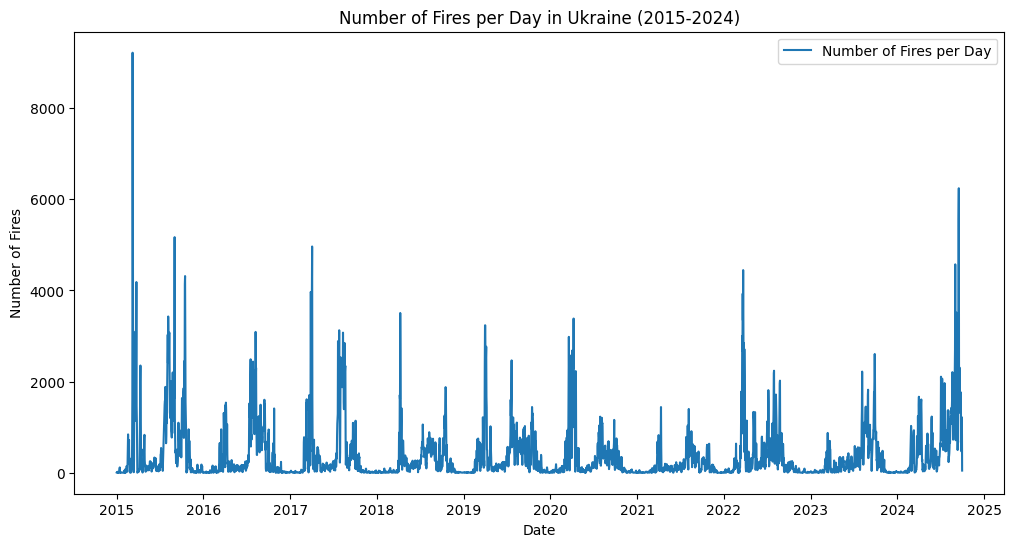

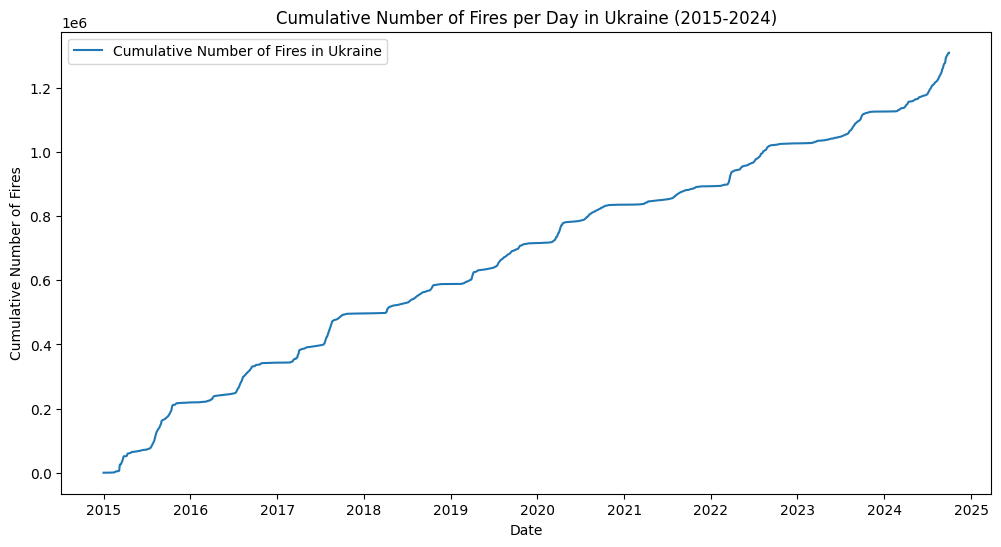

In [138]:
# Load fire data
fire_data = pd.read_csv('input_data/processed/fire_data.csv')

# Convert the ACQ_DATE column to datetime
fire_data['ACQ_DATE'] = pd.to_datetime(fire_data['ACQ_DATE'])

# Group by date and count the number of fires per day
fires_per_day = fire_data.groupby('ACQ_DATE').size().reset_index(name='fire_count')

# Plot the number of fires per day
plt.figure(figsize=(12, 6))
plt.plot(fires_per_day['ACQ_DATE'], fires_per_day['fire_count'], label='Number of Fires per Day')
plt.xlabel('Date')
plt.ylabel('Number of Fires')
plt.title('Number of Fires per Day in Ukraine (2015-2024)')
plt.legend()
plt.show()

# Calculate the cumulative sum of fires per day for all of Ukraine
fires_per_day['cumulative_fire_count'] = fires_per_day['fire_count'].cumsum()

# Plot the cumulative sum of fires per day
plt.figure(figsize=(12, 6))
plt.plot(fires_per_day['ACQ_DATE'], fires_per_day['cumulative_fire_count'], label='Cumulative Number of Fires in Ukraine')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Fires')
plt.title('Cumulative Number of Fires per Day in Ukraine (2015-2024)')
plt.legend()
plt.show()

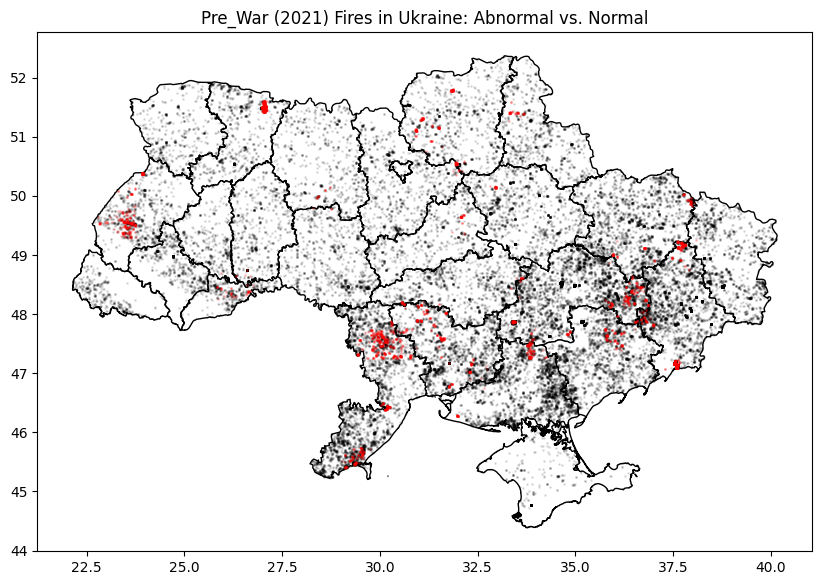

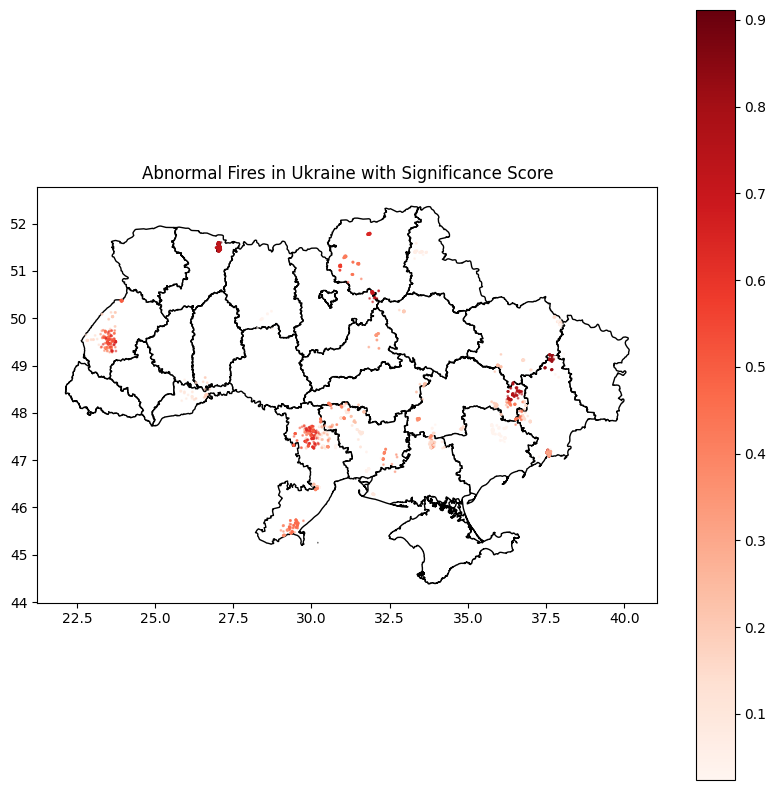

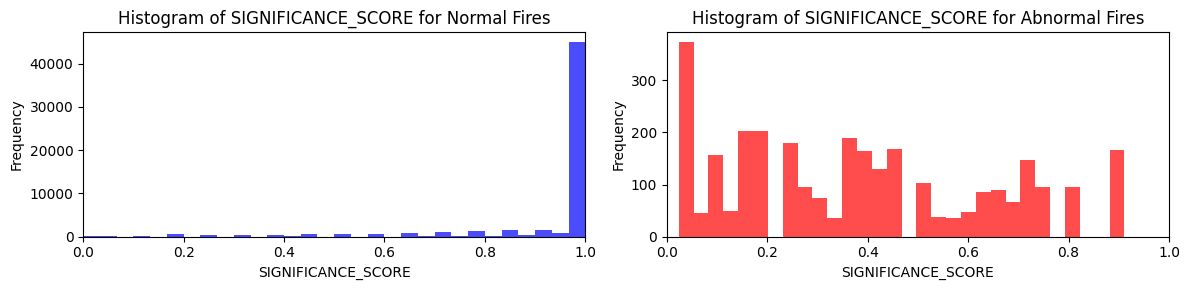

In [142]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_validation.csv')

# Separate the data into OOD and non-OOD fires
fire_data = [fire_data[fire_data['ABNORMAL_LABEL'] == False], fire_data[fire_data['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fire_data, 'input_data/raw/ukr_borders/ua.shp', 
                f'Pre_War (2021) Fires in Ukraine: Abnormal vs. Normal', 
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fire_data[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fire_data)

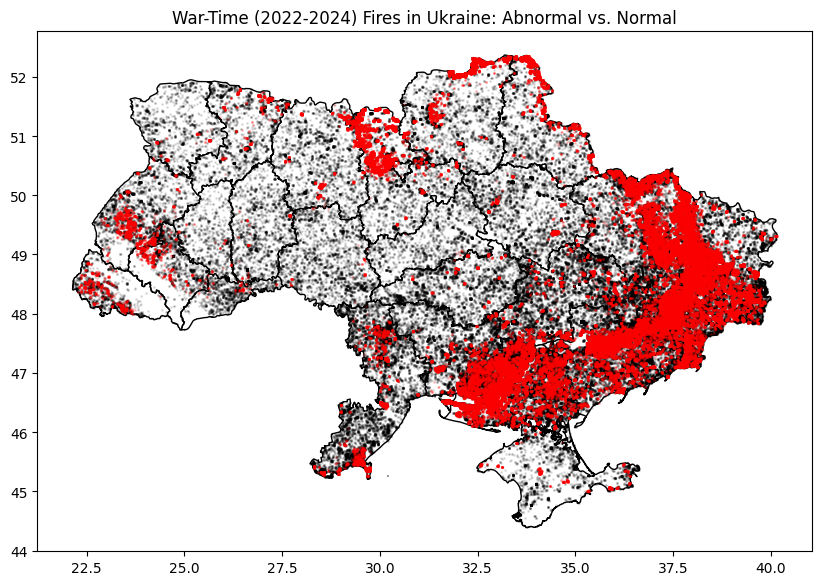

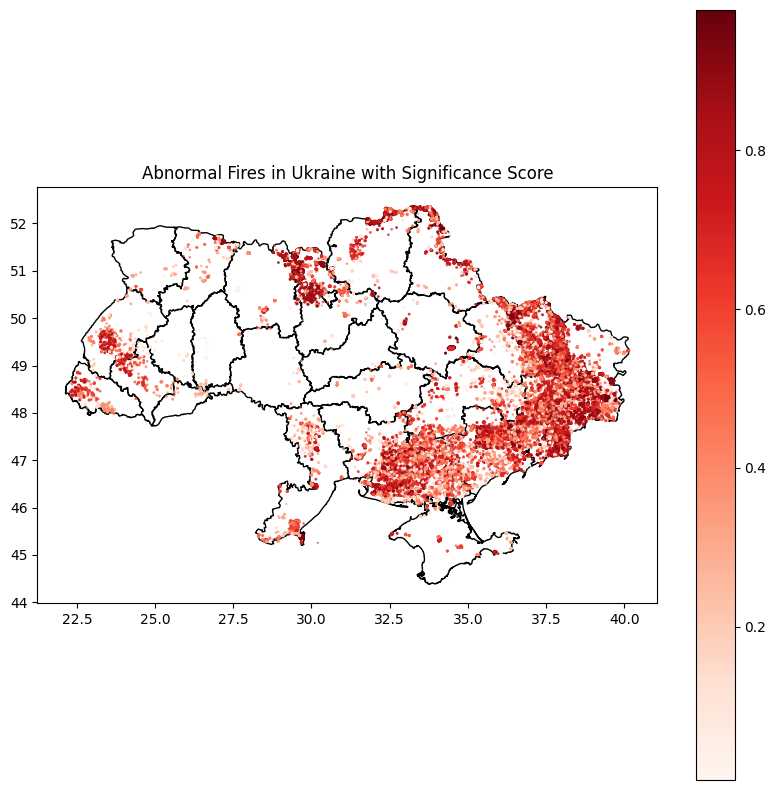

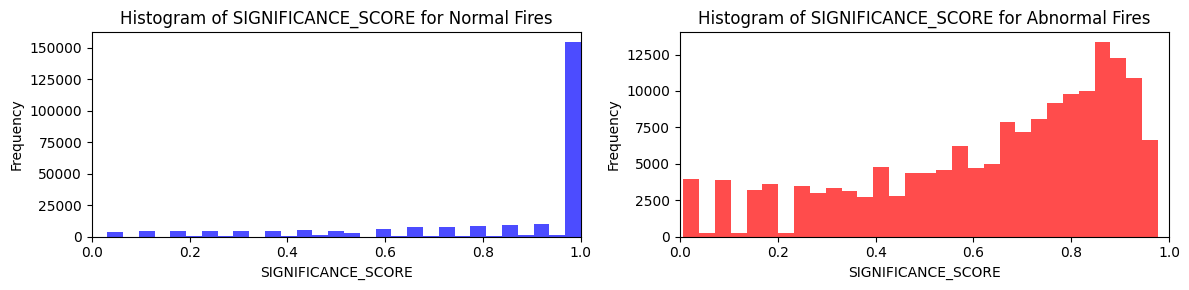

In [143]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')

# Separate the data into OOD and non-OOD fires
fire_data = [fire_data[fire_data['ABNORMAL_LABEL'] == False], fire_data[fire_data['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fire_data, 'input_data/raw/ukr_borders/ua.shp', 
                f'War-Time (2022-2024) Fires in Ukraine: Abnormal vs. Normal',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fire_data[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fire_data)

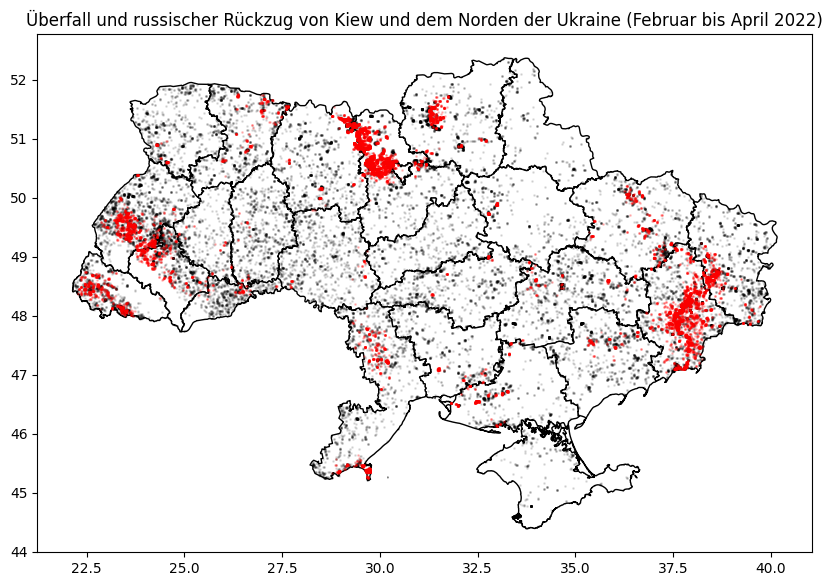

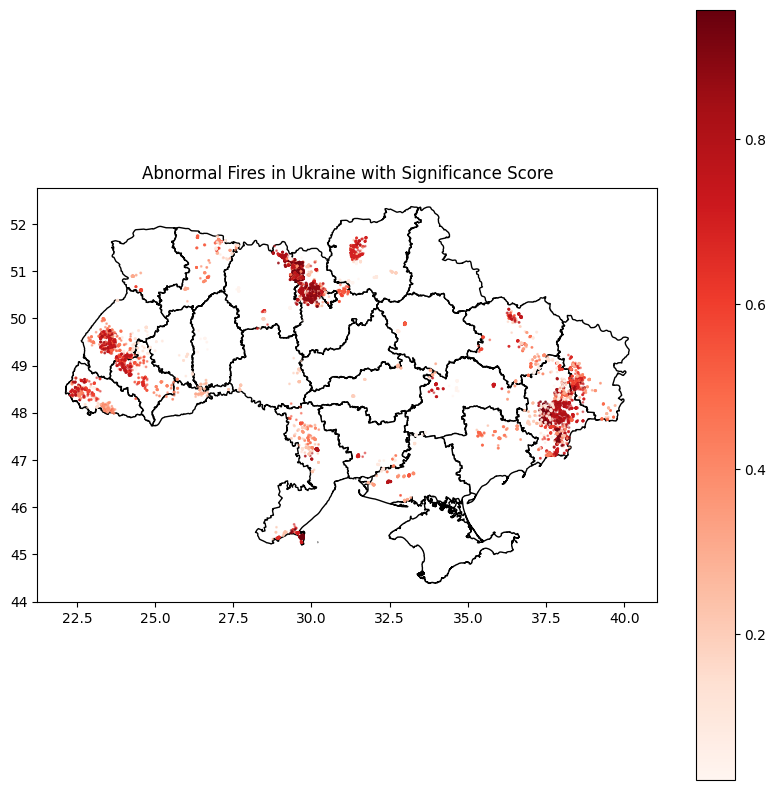

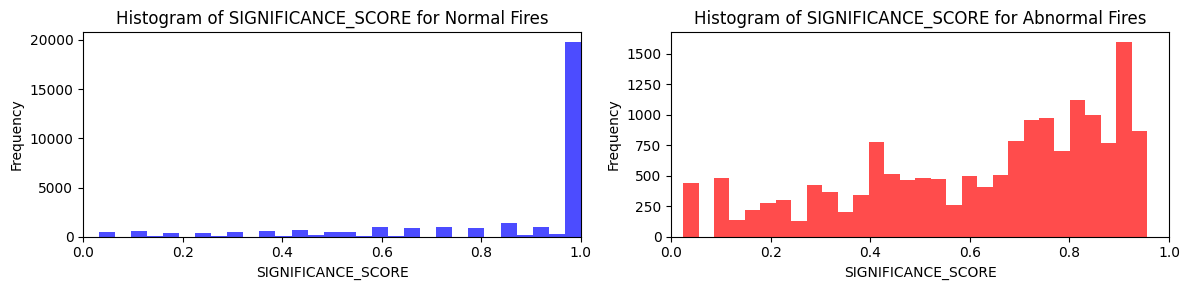

In [144]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2022-02-24') & (fire_data['ACQ_DATE'] <= '2022-04-30')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Überfall und russischer Rückzug von Kiew und dem Norden der Ukraine (Februar bis April 2022)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

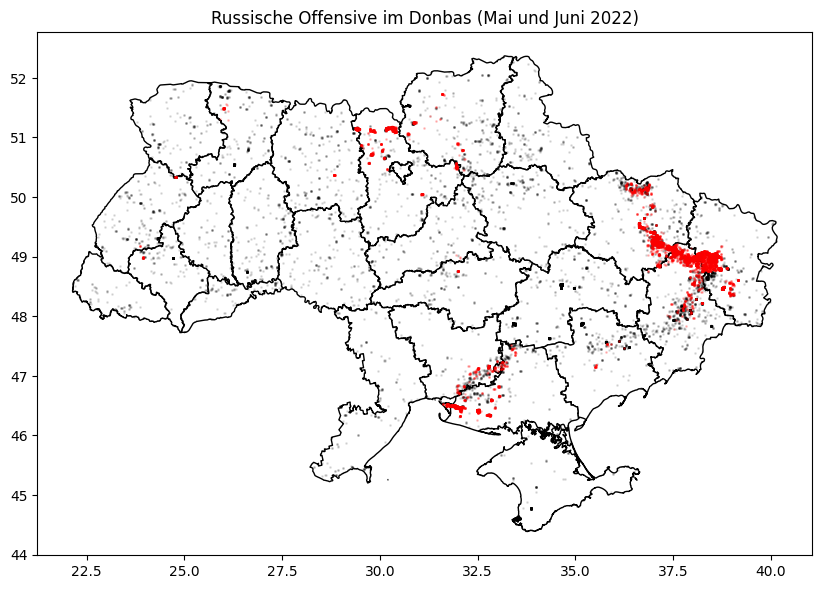

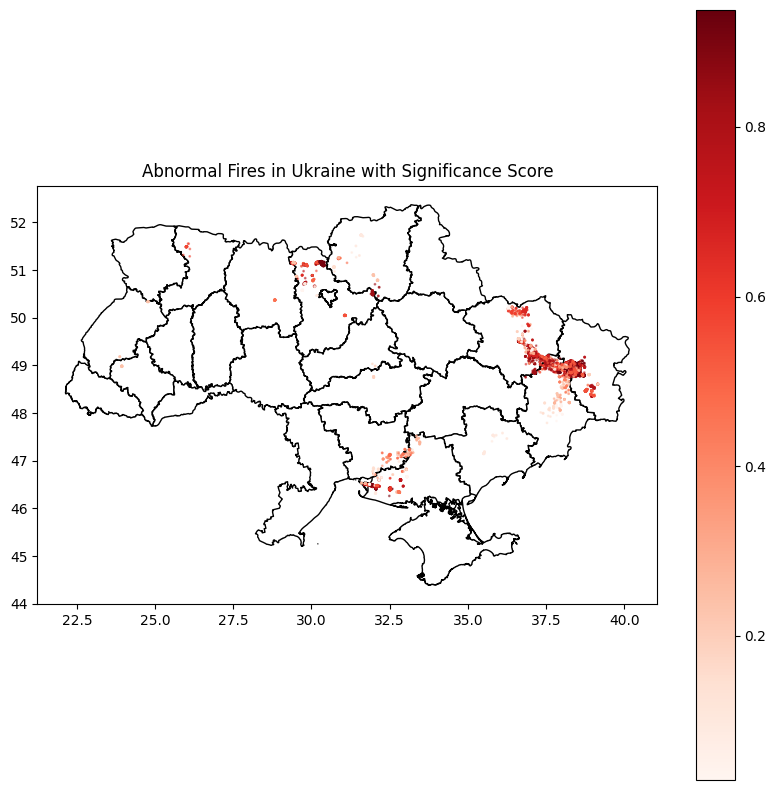

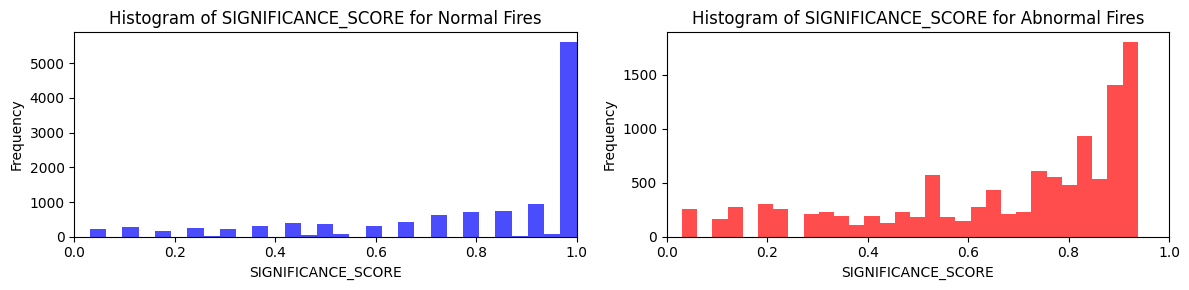

In [145]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2022-05-01') & (fire_data['ACQ_DATE'] <= '2022-06-30')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Russische Offensive im Donbas (Mai und Juni 2022)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

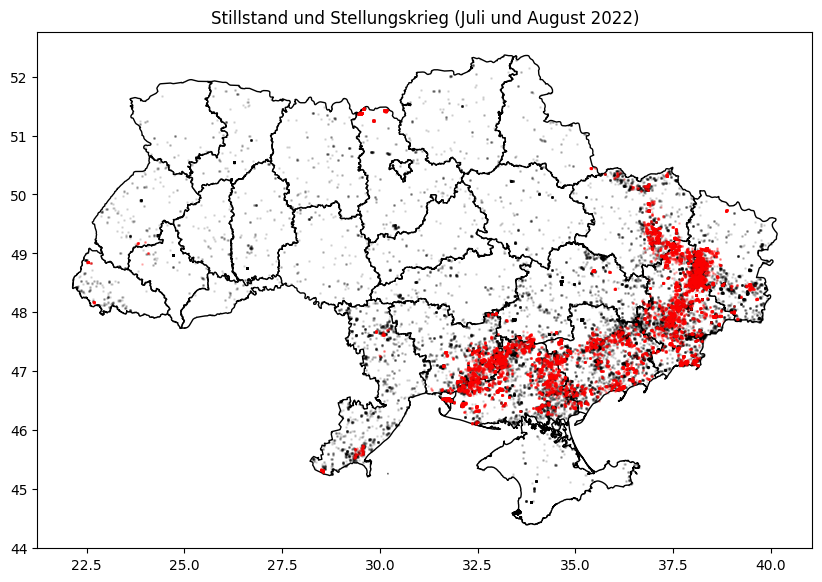

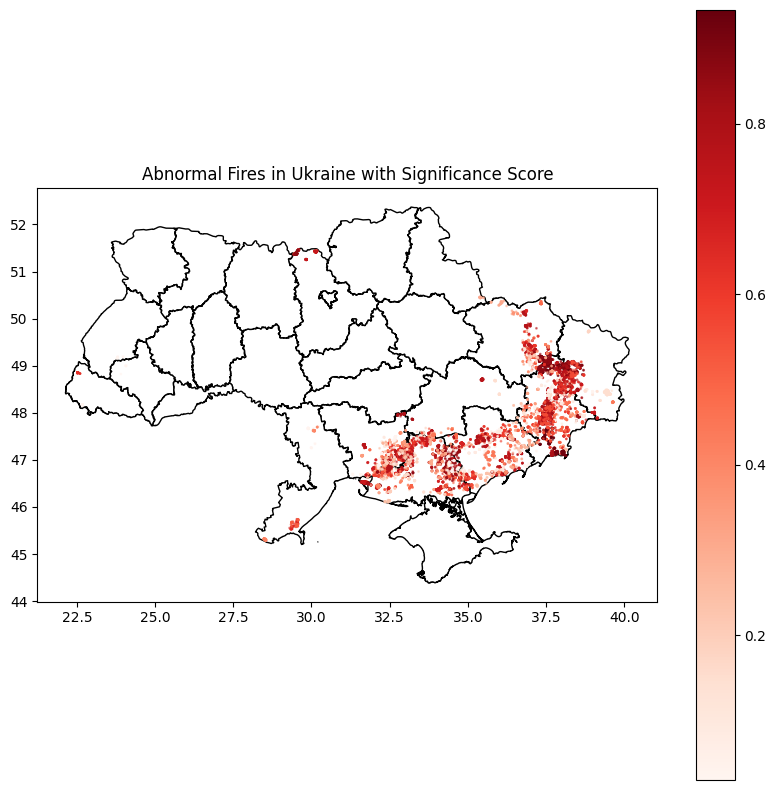

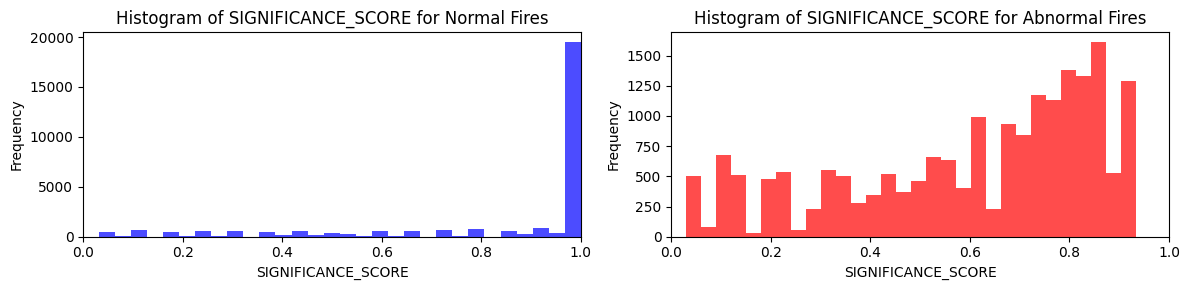

In [146]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2022-07-01') & (fire_data['ACQ_DATE'] <= '2022-08-30')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Stillstand und Stellungskrieg (Juli und August 2022)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

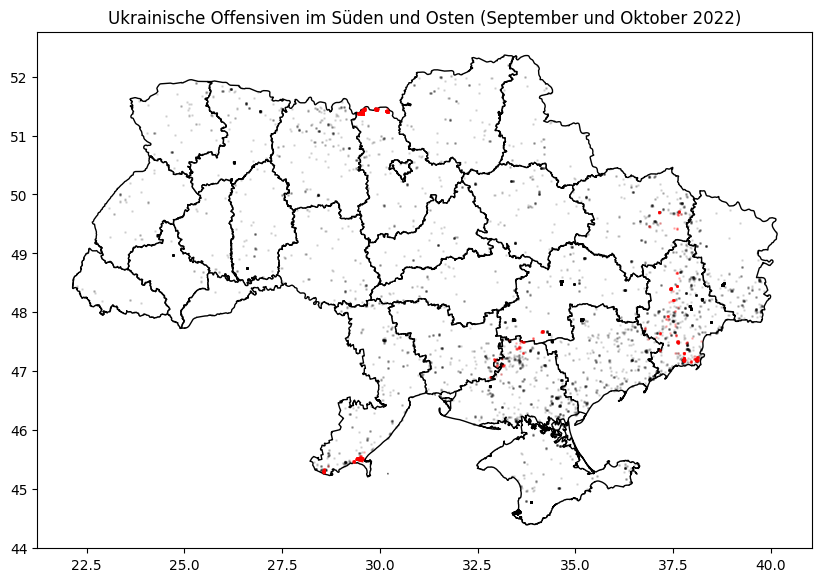

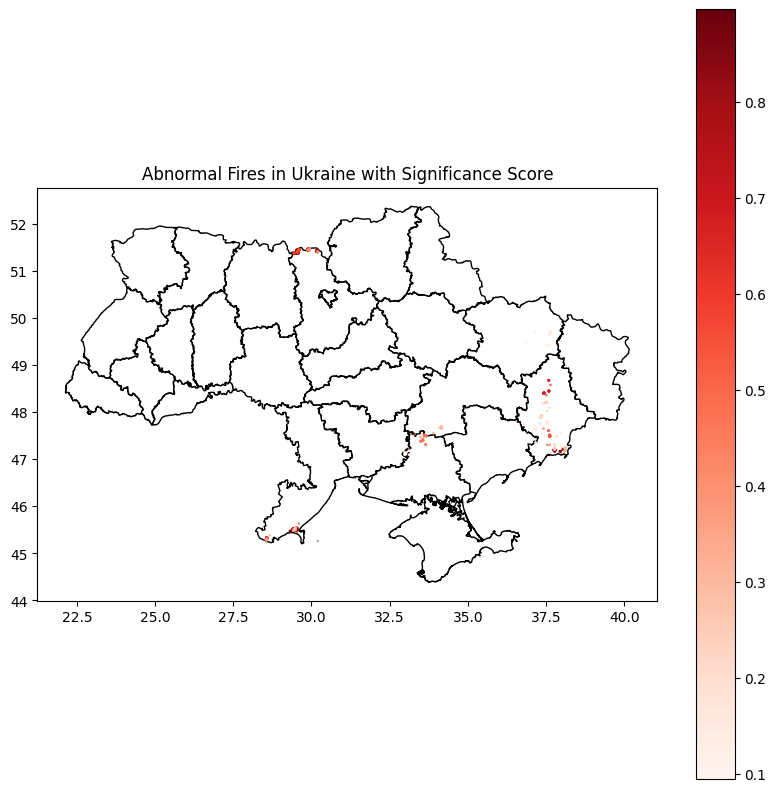

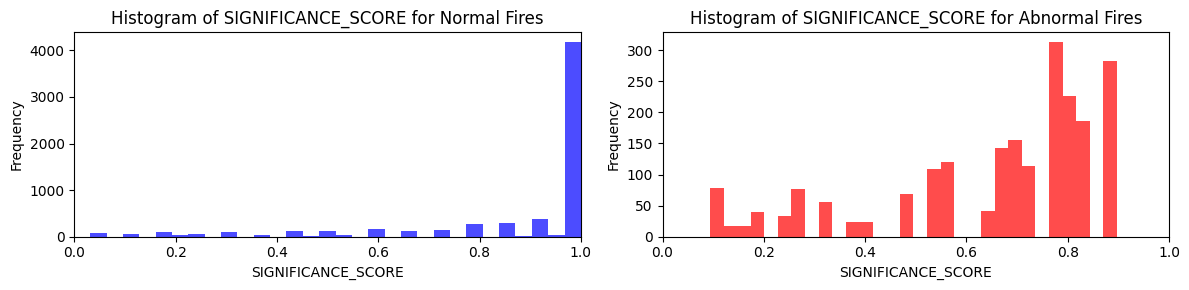

In [147]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2022-09-01') & (fire_data['ACQ_DATE'] <= '2022-10-31')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Ukrainische Offensiven im Süden und Osten (September und Oktober 2022)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

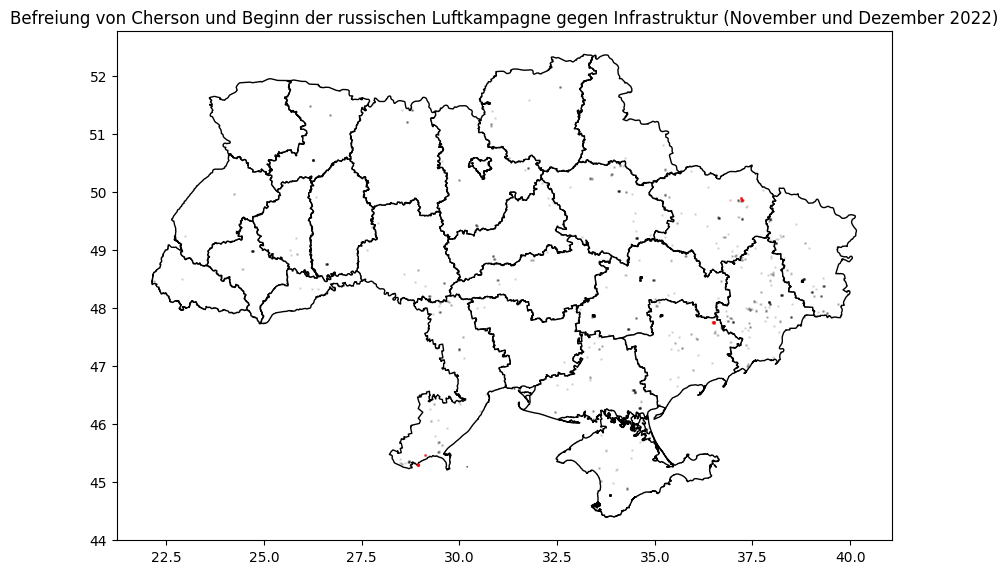

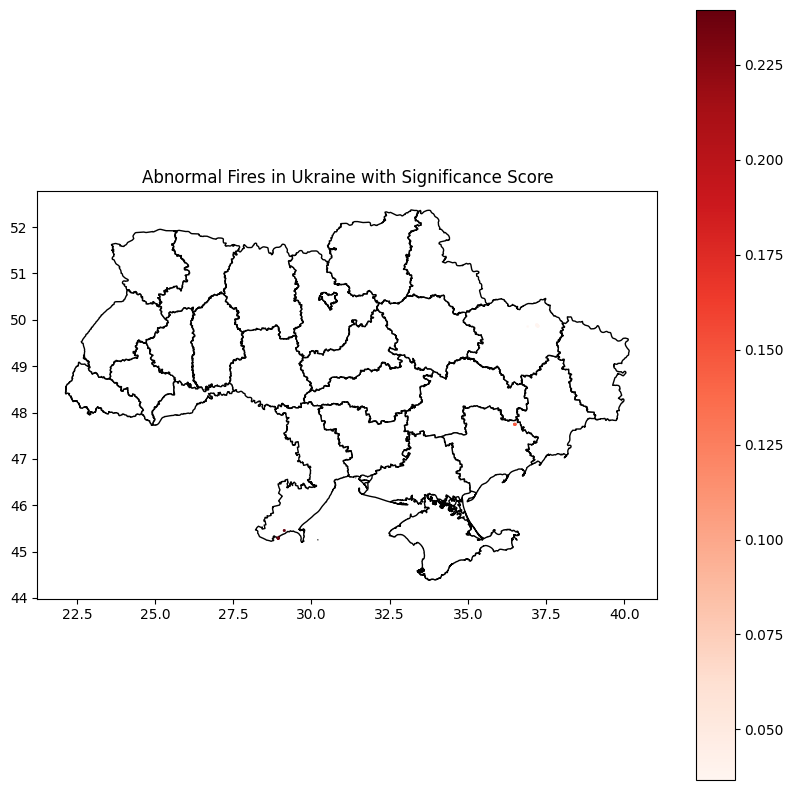

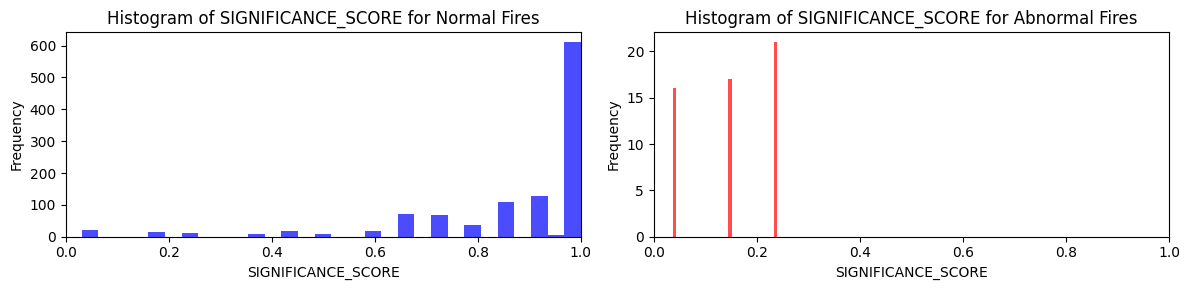

In [148]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2022-11-01') & (fire_data['ACQ_DATE'] <= '2022-12-31')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Befreiung von Cherson und Beginn der russischen Luftkampagne gegen Infrastruktur (November und Dezember 2022)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

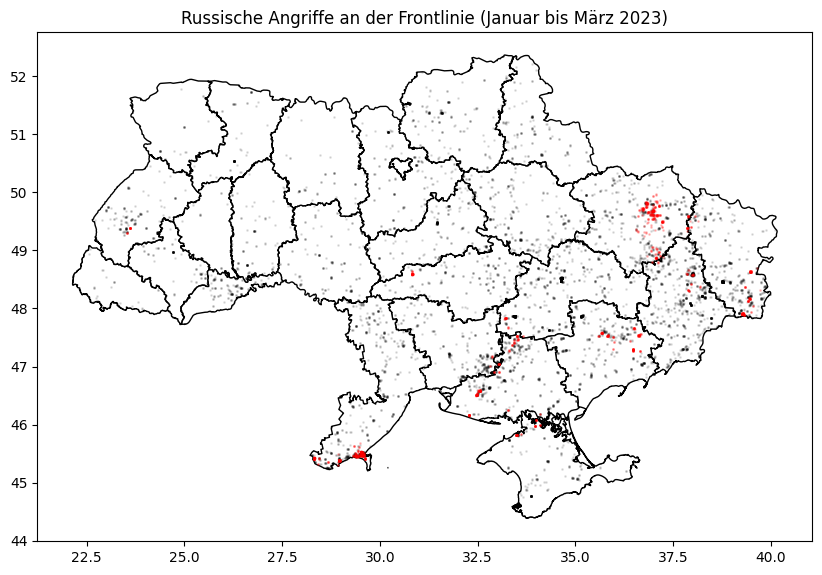

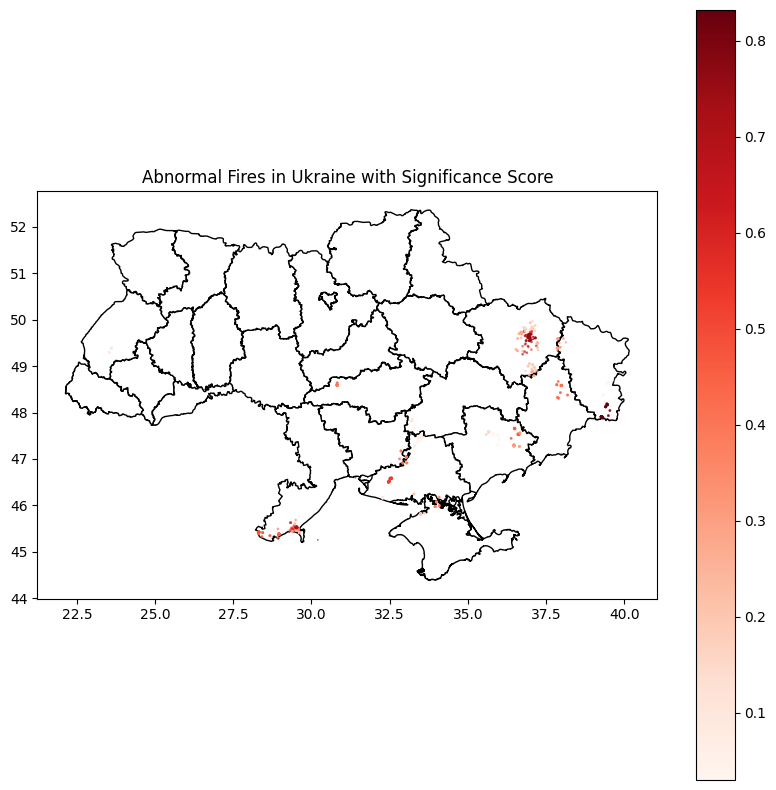

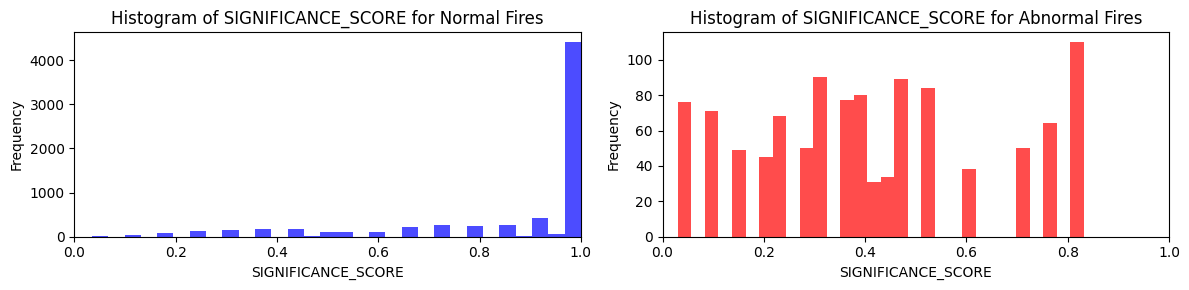

In [154]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2023-01-01') & (fire_data['ACQ_DATE'] <= '2023-03-31')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Russische Angriffe an der Frontlinie (Januar bis März 2023)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

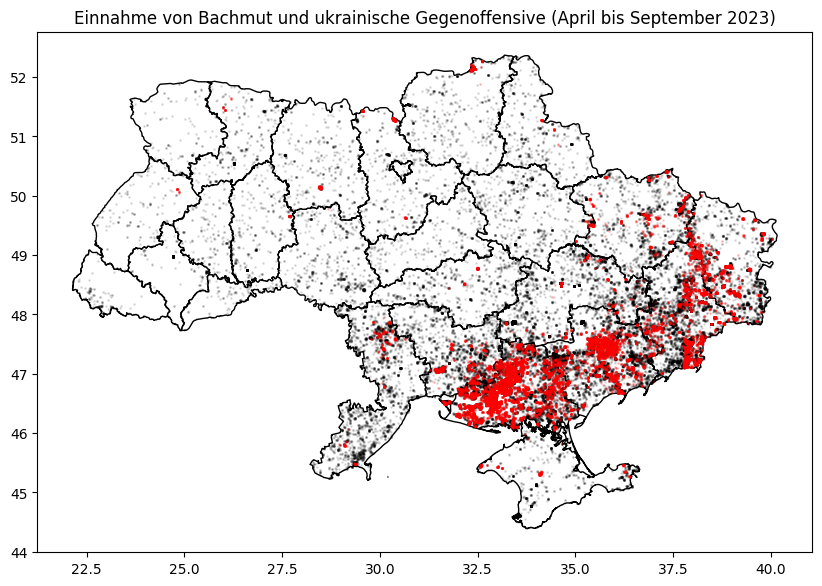

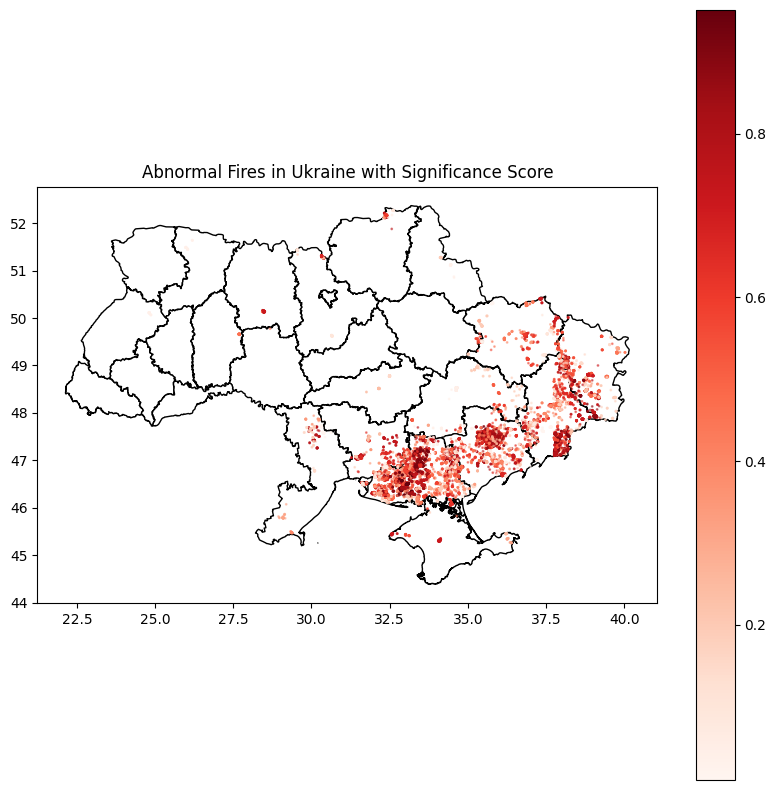

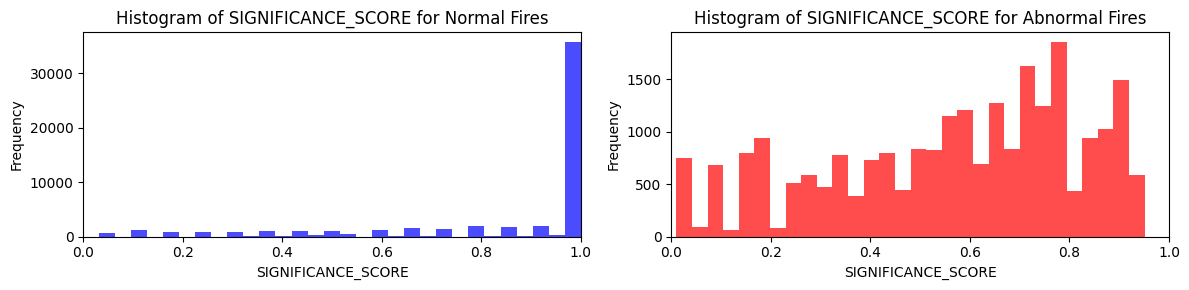

In [155]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2023-04-01') & (fire_data['ACQ_DATE'] <= '2023-09-30')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Einnahme von Bachmut und ukrainische Gegenoffensive (April bis September 2023)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

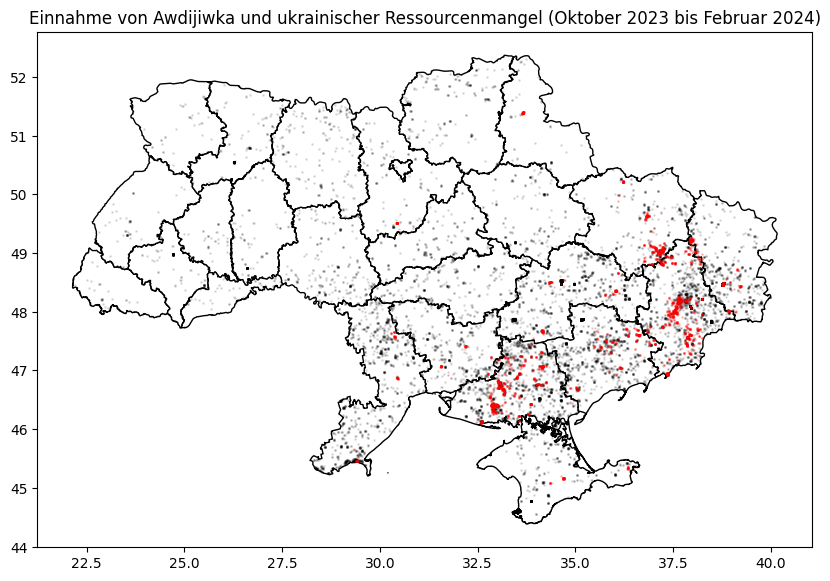

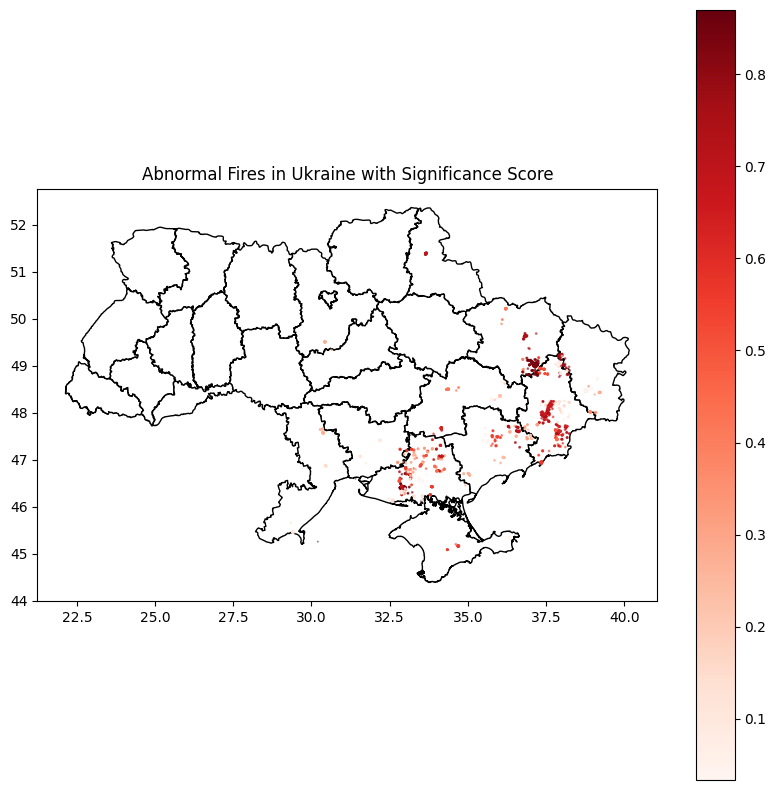

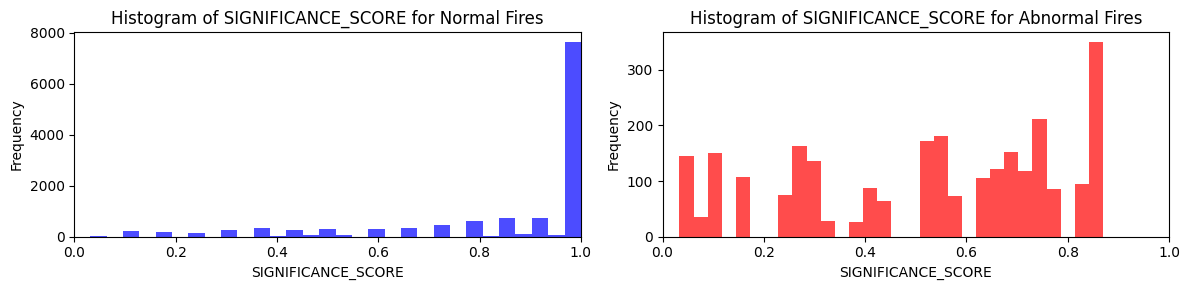

In [156]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2023-10-01') & (fire_data['ACQ_DATE'] <= '2024-02-28')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Einnahme von Awdijiwka und ukrainischer Ressourcenmangel (Oktober 2023 bis Februar 2024)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

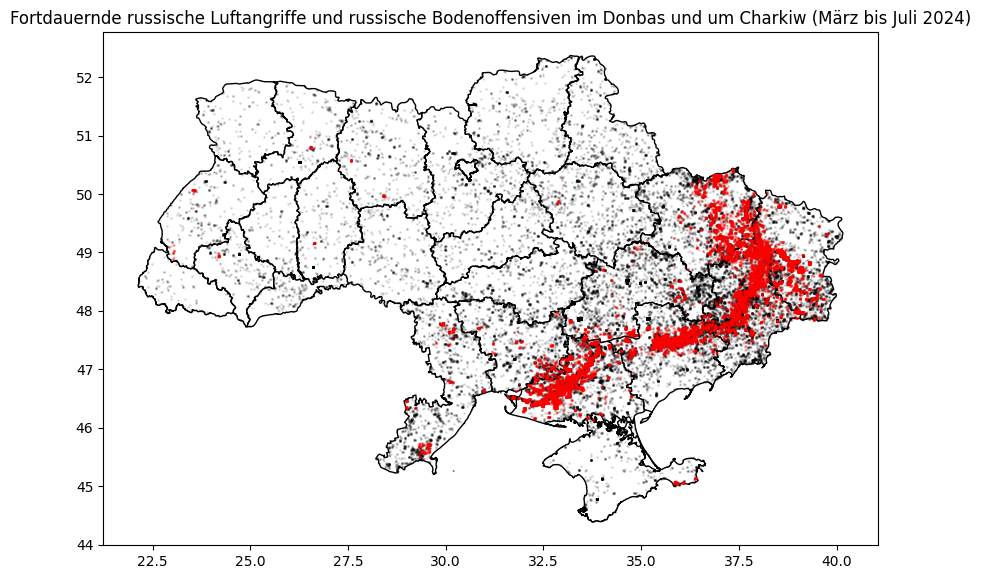

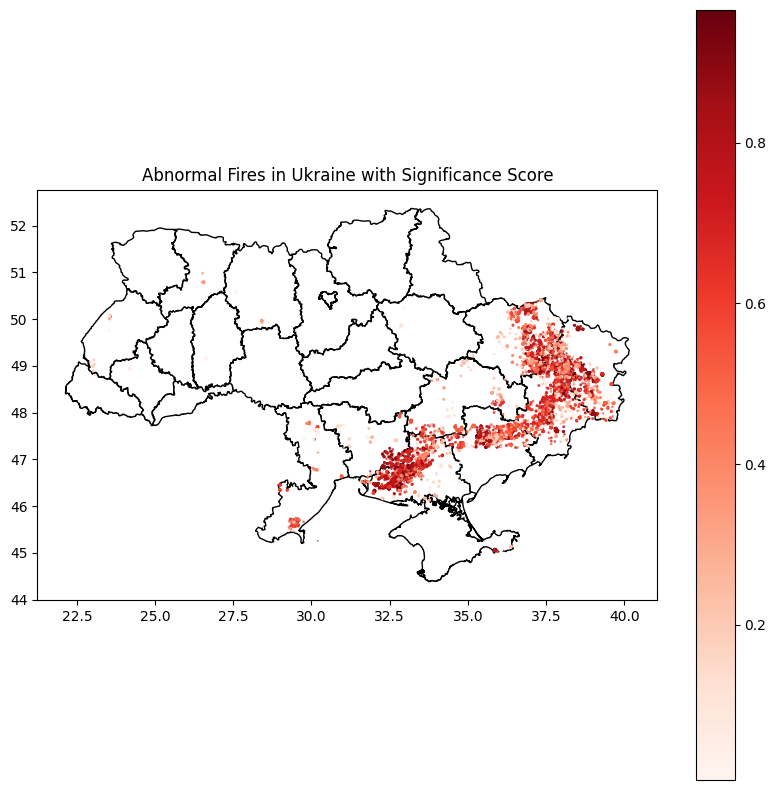

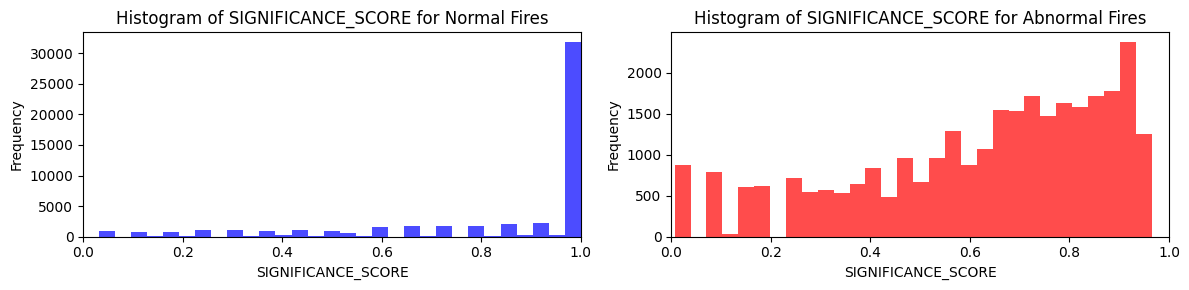

In [157]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2024-03-01') & (fire_data['ACQ_DATE'] <= '2024-07-30')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Fortdauernde russische Luftangriffe und russische Bodenoffensiven im Donbas und um Charkiw (März bis Juli 2024)',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)

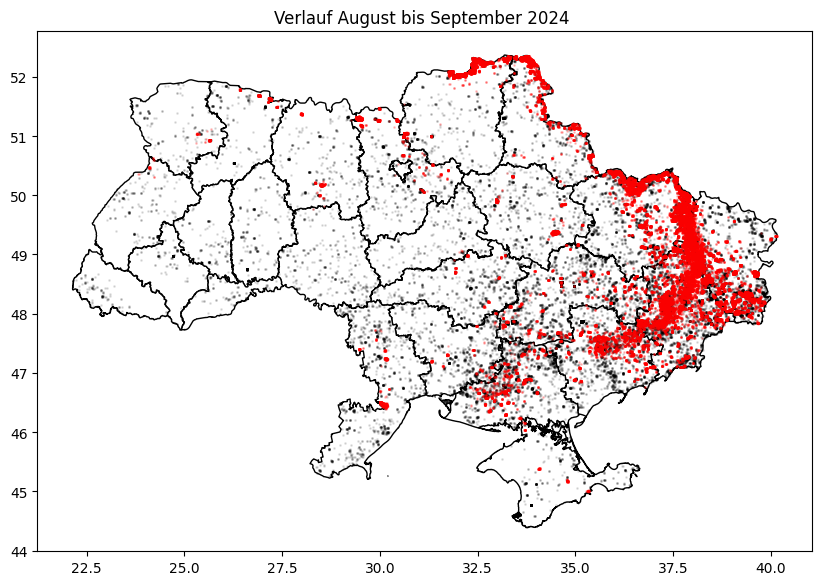

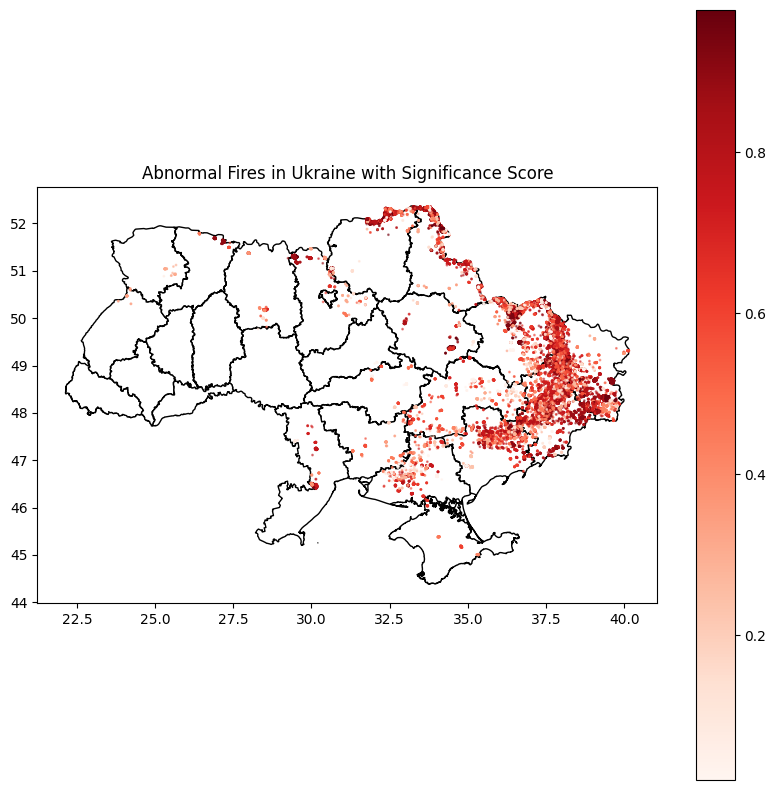

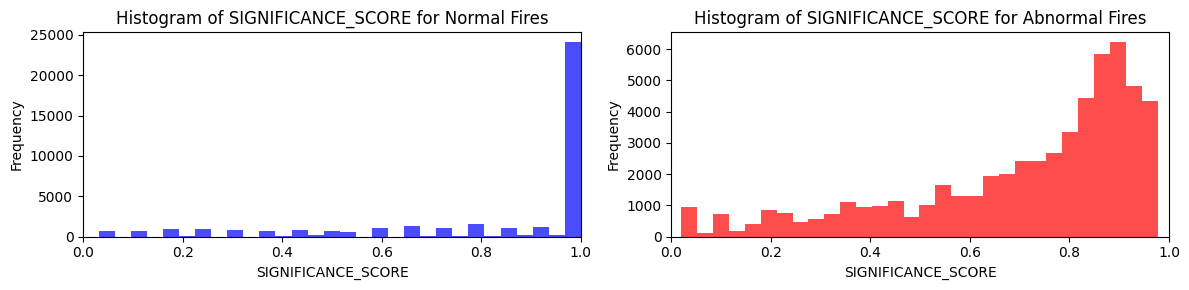

In [158]:
# Load fire data
fire_data = pd.read_csv('output_data/abnormal_fires_test.csv')
                        
# Filter fire data for the specified date range
fires_week = fire_data[(fire_data['ACQ_DATE'] >= '2024-08-01') & (fire_data['ACQ_DATE'] <= '2024-09-30')]

# Separate the data into OOD and non-OOD fires
fires_week = [fires_week[fires_week['ABNORMAL_LABEL'] == False], fires_week[fires_week['ABNORMAL_LABEL'] == True]]

# Plot the fires colored by OOD label
plot_ukr_fires(fires_week, 'input_data/raw/ukr_borders/ua.shp', 
                f'Verlauf August bis September 2024 ',
                colors=['black', 'red'], 
                alphas=[0.1, 0.2], 
                markersizes=[1,1], 
                columns=[None, None], 
                legend=True)

# Plot the abnormal fires in Ukraine using the significance score for color intensity
plot_ukr_fires([fires_week[1]], 'input_data/raw/ukr_borders/ua.shp', 
               'Abnormal Fires in Ukraine with Significance Score', 
               cmaps=['Reds'], alphas=[0.5], markersizes=[1], columns=['SIGNIFICANCE_SCORE'], legend=True)

# Plot the histogram
plot_significance_score_histogram(fires_week)